(100, 100)


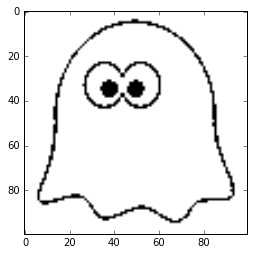

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import colorsys
import copy
import time
import sys
from tqdm import tqdm
from PIL import Image

#img = Image.open('dragon_200.png')
#img = Image.open('pattern.png')
#img = Image.open('ghost_200.png')
img = Image.open('duch100.png')
img = img.convert('RGB')

print(img.size)
plt.imshow(img)


In [2]:
TILE_SIZE = 5 # Size of the tile => 10x10
BITS = 1       # Color depth

class Tile:
    def get_pixel(self, x, y):
        return self.pixels[x][y]
    
    def to_binary(self):
        if (BITS == 8):
            binary = [bin(x)[2:].zfill(8) for x in self.pixels.flatten()]
            return np.array([list(map(int, x)) for x in binary]).flatten()
        if (BITS == 1):
            binary = []
            for x in self.pixels.flatten():
                assert(x == 255 or x == 0)
                binary.append(x // 255)
            return np.array(binary)
    
    def __init__(self, pixels):
        self.pixels = pixels
        
def tile_equals(tile1, tile2):
    return np.array_equal(tile1.pixels.flatten(), tile2.pixels.flatten())


In [3]:
WIDTH = img.size[0]
HEIGHT = img.size[1]

tiles_x = WIDTH // TILE_SIZE
tiles_y = HEIGHT // TILE_SIZE

def get_tiles_from_img(img):
    img_data = np.array(img.getdata()).reshape(WIDTH, HEIGHT, 3) 
    print("Img data shape: ", img_data.shape)
    
    tiles = []
    for x in range(tiles_x):
        for y in range(tiles_y):
            pixels = []
            count = 0
            for offset_x in range(TILE_SIZE):
                for offset_y in range(TILE_SIZE):
                    pixels.append(img_data[x * TILE_SIZE + offset_x][y * TILE_SIZE + offset_y])
                
            tiles.append(Tile(np.array(pixels).reshape(TILE_SIZE, TILE_SIZE, 3)))
    
    return np.array(tiles)

In [4]:
def get_rotations_of_tile(tile):
    #rotated = [copy.deepcopy(tile)]
    rotated = [tile]
    
    for i in range(1, 4):
        rotated.append(Tile(np.rot90(tile.pixels, i)))
        return rotated

In [5]:
def show_tiles(tiles):
    reshaped_tiles = tiles.reshape(tiles_x, tiles_y)
    pixels = np.empty([WIDTH, HEIGHT, 3])
    for x in range(tiles_x):
        for y in range(tiles_y):
            for offset_x in range(TILE_SIZE):
                for offset_y in range(TILE_SIZE):
                    tile = reshaped_tiles[x][y]
                    pixels[x * TILE_SIZE + offset_x][y * TILE_SIZE + offset_y] = tile.get_pixel(offset_x, offset_y)
    
    im = Image.fromarray(np.uint8(pixels).reshape(HEIGHT, WIDTH, 3))
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Original')
    
    plt.subplot(1,2,2)
    plt.imshow(im)
    plt.title('Predicted')
    
def to_color_depth_8(binary):
    r = binary[0:BITS]
    g = binary[BITS:2*BITS]
    b = binary[2*BITS:3*BITS]

    if (BITS == 1):
        if ((r + g + b)[0] == 3):
            return [255, 255, 255]
        if ((r + g + b)[0] == 0):
            return [0, 0, 0]
        else:
            return [255, 0, 0]
        
    if (BITS == 8):
        result = []
        for color in [r, g, b]:
            binar = map(str, color)
            result.append(int(''.join(binar), 2))
        return result

def predicted_to_tiles(predicted):
    tiles = []
    for pred in predicted:
        reshaped = pred.reshape(TILE_SIZE * TILE_SIZE, 3, BITS)
        pixels = [to_color_depth_8(x.flatten()) for x in reshaped]
        tiles.append(Tile(np.array(pixels).reshape(TILE_SIZE, TILE_SIZE, 3)))
    return np.array(tiles)

In [6]:
assert(WIDTH % TILE_SIZE == 0 and HEIGHT % TILE_SIZE == 0)

In [7]:
tiles = get_tiles_from_img(img)

train_x = [t.to_binary() for t in tiles]
train_y = np.copy(train_x)

Img data shape:  (100, 100, 3)


In [8]:
def show_used_tiles(unique_tiles, title):
    tile_counts = np.array([0] * len(unique_tiles))
    for i in range(len(tile_counts)):
        for t in tiles_predicted:
            if (tile_equals(t, unique_tiles[i])):
                tile_counts[i] += 1
    
    plt.figure(figsize=(12, 30))
    for i in range(1, len(unique_tiles) + 1):
        im = Image.fromarray(np.uint8(unique_tiles[i-1].pixels))
        plt.subplot(20,8,i)
        title = "{}x".format(tile_counts[i-1])
        plt.title(title)
        plt.gca().axes.get_xaxis().set_ticks([])
        plt.gca().axes.get_yaxis().set_ticks([])
        plt.imshow(im, interpolation='none')
    plt.tight_layout()
    
def show_tiles_matrix(tiles_predicted):
    unique_tiles = []
    uniq_rotations_checked = []
    rotations_used = []

    for t in tiles_predicted:
        used_tile = False
        used_rotated = False
        for u in unique_tiles:
            if tile_equals(t, u):
                used_tile = True
                break
            for rot in get_rotations_of_tile(u):
                if tile_equals(t, rot):
                    used_rotated = True
                    break
        if not used_tile:
            unique_tiles.append(t)
            if used_rotated:
                rotations_used.append(t)
            else:
                uniq_rotations_checked.append(t)
    
    print("Tile size: ", TILE_SIZE)
    print("Used tile types: ", len(unique_tiles))
    print("Used tiles (rotation check): ", len(uniq_rotations_checked))
    if (len(unique_tiles) > 150):
        print("Too many tiles to show")
    else:
        if (len(rotations_used) > 0):
            show_used_tiles(rotations_used, "Rotations used")
        show_used_tiles(unique_tiles, "All used")   

#### Hidden layer sizes

In [9]:
from scipy import misc
HIDDEN_1 = 8
HIDDEN_2 = 16
throughput = 0
for i in range(HIDDEN_1 + 1):
    throughput += misc.comb(HIDDEN_2, i, exact=1)
print("Max throughput (between two hidden layers): ", throughput)

Max throughput (between two hidden layers):  39203


In [10]:
def get_model_score(tiles, tiles_predicted):
    error = 0
    for i in range(len(tiles)):
        error += sum([1 for x in (tiles[i].pixels.flatten() - tiles_predicted[i].pixels.flatten()) if x != 0])
    return float(error) / (len(tiles) * TILE_SIZE * TILE_SIZE * 3 * BITS)

#### Standard fit

C:\Anaconda2\envs\py3k\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Model score (train data):  0.9862666666666666
Iterations:  2000


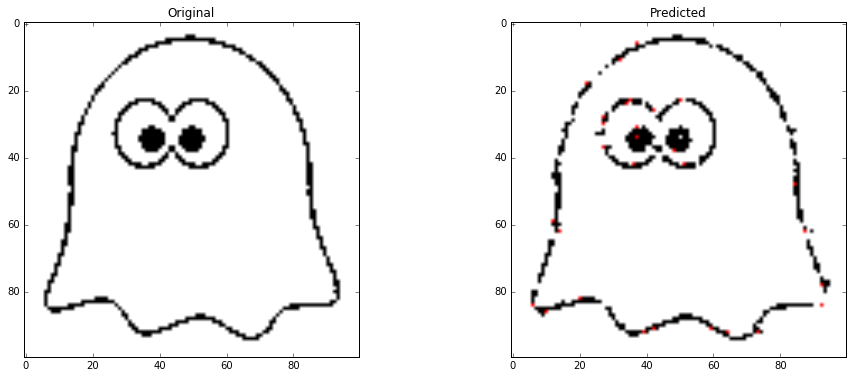

In [11]:
STANDARD_FIT = True
if (STANDARD_FIT):
    from sklearn import neural_network as nn
    clf = nn.MLPClassifier(hidden_layer_sizes=(HIDDEN_1, HIDDEN_2),
                           activation='relu',
                           solver='adam',
                           alpha=0.0001,
                           shuffle=True,
                           verbose=False,
                           warm_start=False,
                           tol=-1000,
                           validation_fraction=0,
                           max_iter=2000,
                           learning_rate='constant',
                           learning_rate_init=0.001)
    
    model = clf.fit(train_x, train_y)
    predicted = model.predict(train_x)
    tiles_predicted = predicted_to_tiles(predicted)
    
    print("Model score (train data): ", 1 - get_model_score(tiles, tiles_predicted))
    print("Iterations: ", len(model.loss_curve_))
          
    show_tiles(tiles_predicted)

Tile size:  5
Used tile types:  90
Used tiles (rotation check):  83


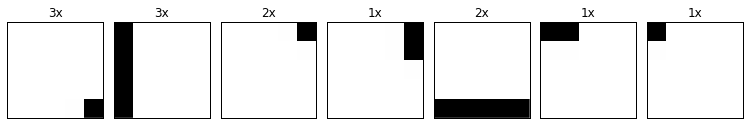

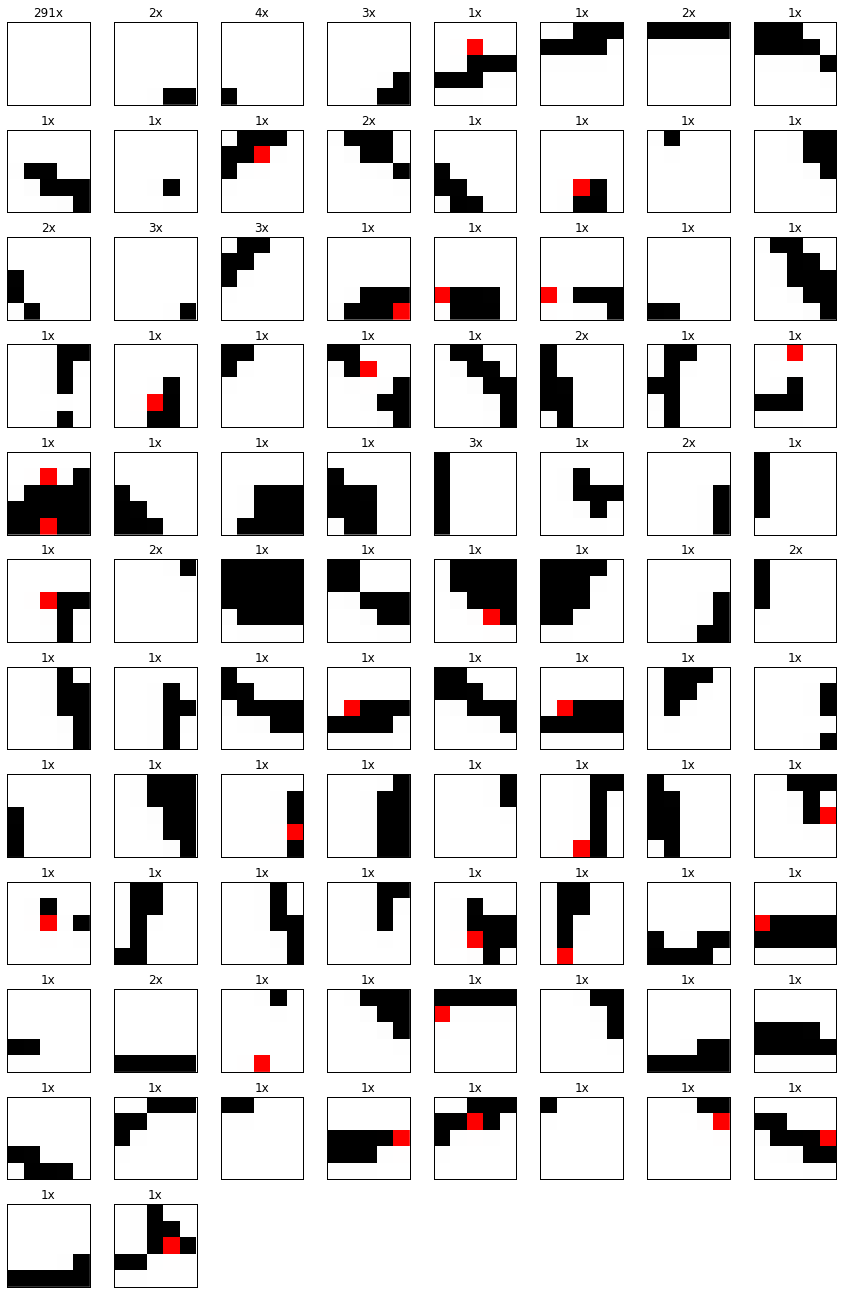

In [12]:
if (STANDARD_FIT):
    show_tiles_matrix(tiles_predicted)

#### Partial fit using rotations of tiles

In [13]:
def show_iter_number(value, max_iter, start_time):
    completed_percentage = value / max_iter
    bars = round(20 * completed_percentage)
    for i in range(value+1):
        sys.stdout.write('\r')
        sys.stdout.write("[%-20s] %d%%" % ('='*bars, completed_percentage * 100))
        time_string = " time:" + str(time.time() - start_time) + "s"
        sys.stdout.write(time_string)
        sys.stdout.flush()

Img data shape:  (100, 100, 3)


C:\Anaconda2\envs\py3k\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
100%|████████████████████████████████████████| 101/101 [01:29<00:00,  1.15it/s]



Model score (train data):  0.9390000000000001


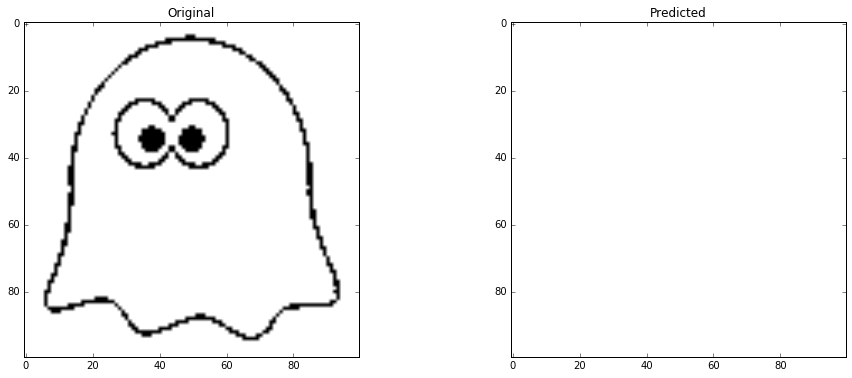

In [14]:
MAX_ITER = 100
ROTATIONS = True

if ROTATIONS:
    from sklearn import neural_network as nn
    clf = nn.MLPClassifier(hidden_layer_sizes=(HIDDEN_1, HIDDEN_2),
                           activation='relu',
                           solver='adam',
                           alpha=0.0001,
                           shuffle=True,
                           verbose=False,
                           warm_start=True,
                           tol=-1000,
                           validation_fraction=0,
                           max_iter=1,
                           learning_rate='constant',
                           learning_rate_init=0.001)
    
    tiles = get_tiles_from_img(img)
    initial_fit = [tiles[0].to_binary()]
    clf.fit(initial_fit, initial_fit)
    
    start = time.time()
    # TRAIN
    for it in tqdm(range(MAX_ITER+1)):
        for tile in tiles:
            rotated_tiles = get_rotations_of_tile(tile)
            predictions = clf.predict([t.to_binary() for t in rotated_tiles])
            tiles_predicted = predicted_to_tiles(predictions)
            
            errors = []
            for i in range(len(rotated_tiles)):
                errors.append(get_model_score([rotated_tiles[i]], [tiles_predicted[i]]))
            min_index = np.argmin(errors)
            #clf.fit([tile.to_binary()], [rotated_tiles[i].to_binary()])
            clf.fit([rotated_tiles[i].to_binary()], [rotated_tiles[i].to_binary()])
    
    # PREDICT
    result = []
    for tile in tiles:
        rotated_tiles = get_rotations_of_tile(tile)
        predictions = clf.predict([t.to_binary() for t in rotated_tiles])
        tiles_predicted = predicted_to_tiles(predictions)
            
        errors = []
        for i in range(len(rotated_tiles)):
            errors.append(get_model_score([rotated_tiles[i]], [tiles_predicted[i]]))
        min_index = np.argmin(errors)
        
        pred_rotated = Tile(np.rot90(tiles_predicted[min_index].pixels, -min_index))
        result.append(pred_rotated)
    
    tiles_predicted = np.array(result)
    print("\nModel score (train data): ", 1 - get_model_score(tiles, tiles_predicted))
    #print("Iterations: ", len(model.loss_curve_))
          
    show_tiles(tiles_predicted)

Tile size:  5
Used tile types:  1
Used tiles (rotation check):  1


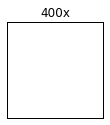

In [15]:
if ROTATIONS:
    show_tiles_matrix(tiles_predicted)  

In [16]:
#plt.plot(model.loss_curve_)
#plt.title('Loss')

## Throughput
Throughput of the network at the point where the network extends (layer i -> j): 

$ n = \text{size of j (bigger layer)  } k = \text{size of i (smaller layer)} $

$$ \sum_{i=0}^{k} {n \choose i} $$